# Projeto Final

**Componentes** 
- Franklin Luiz Soarez do Nascimento Filho
- Niedson Fernando Dantas Fernandes
- Raphael Ramos da Silva
- Poliana Ellen de Araújo

Faça o download de um arquivo de áudio em https://freesound.org/browse/. Utilizando a linguagem Python, execute os seguintes passos:

(a) Plote o sinal no domínio do tempo.

numero de canais = 2
frequencia de amostragem = 44100 Hz
Duração: 47.5s
Número de amostras: 2094750


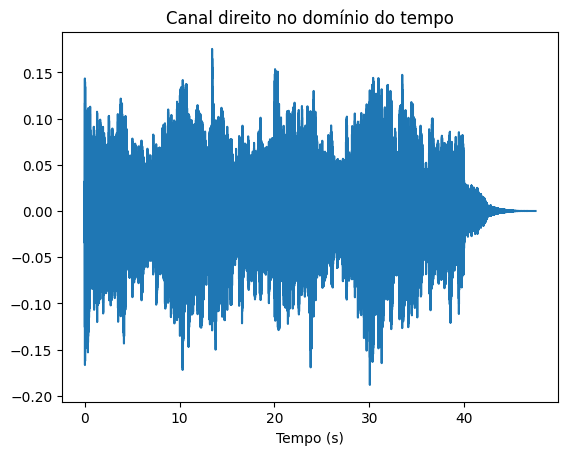

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
from scipy.io import wavfile

# Carrega arquivo de áudio
samplerate, data = wavfile.read('sample_data/689162__deadrobotmusic__soothing-guitar-loop-side-air-guitar-2-96bpm-a-sharp-minor.wav')

# Carrega coeficientes do filtro: L = 3 então a frequencia de corte do filtro é wc = pi/3 rad
coeffs = np.genfromtxt('sample_data/coeffs_hamming.csv', delimiter=',')

# Carrega o arquivo em dois canais (audio estereo)
print(f"numero de canais = {data.shape[1]}")
print(f"frequencia de amostragem = {samplerate} Hz")

# Plot no domínio do tempo de uma sequência x[n] de tempo discreto
def plot_time_domain(x,sr,title):
    # Conversão do domínio
    n = len(x)
    length = n/sr
    time = np.linspace(0., length, n)
    # Informações da sequência
    print(f"Duração: {length}s")
    print(f"Número de amostras: {n}")
    plt.figure()
    plt.xlabel("Tempo (s)")
    plt.title(f"{title}")
    plt.plot(time,x)

# Extrai os canais esquerdo e direito
data_l = data[:, 0]
data_r = data[:, 1]

# Plota o sinal no domínio do tempo
plot_time_domain(data_r,samplerate,"Canal direito no domínio do tempo")

(b) Usando a transformada rápida de Fourier (FFT), de alguma biblioteca de Python, plote o espectro de frequências do sinal para as primeiras N amostras. Use um valor de N adequado. Escalone o eixo de frequências das N amostras da FFT de forma adequada.

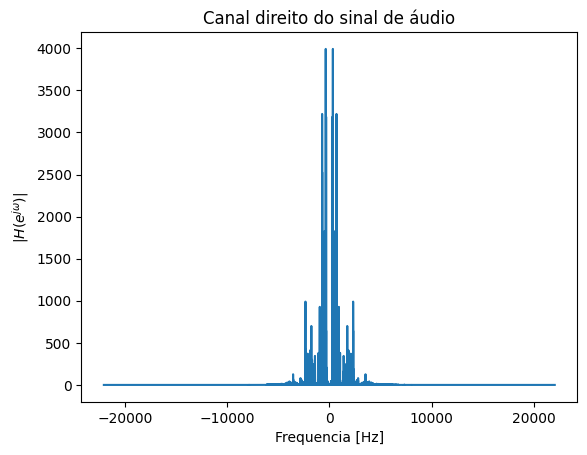

In [49]:
def plot_centered_spectrum(x,n,k,sr,title):
  # Selecionamos a menor potência de dois próxima do numero de amostras
  # Ganho
  N=int(2**(log(n)//log(2)))
  xf = np.fft.fftshift(np.fft.fft(x[:N],N))
  xf_m = np.abs(xf)

  # Eixo horizontal
  n = np.arange(N)
  freqs = np.fft.fftfreq(N,1/sr)
  f = np.fft.fftshift(freqs)

  # Plot
  plt.figure()
  plt.title(title)
  plt.ylabel("$|H(e^{j\omega})|$")
  plt.xlabel("Frequencia [Hz]")
  plt.plot(f[:N//k],xf_m[:N//k])

# Plotar espectro original do canal direito
plot_centered_spectrum(data_r,len(data_r),1,samplerate,"Canal direito do sinal de áudio")

(c) Utilizando os conceitos de mudança de taxa de amostragem vistos em aula, interpole o sinal por um
fator L = 3

(c.1) Fazendo uso da biblioteca pyFDA, projete um filtro passa-baixas digital, com resposta ao impulso finita (FIR), adequado para a interpolação por L = 3

In [50]:
# Coloca L - 1 zeros entre os elementos do array
def put_zeros(arr,L):
  i = 0
  n = len(arr)
  length = L*(n - 1) + 1
  expanded_arr = np.zeros(length)
  while i < length:
    expanded_arr[i] = arr[i//L]
    i += L
  return expanded_arr

# Adiciona L-1 zeros no canal esquerdo e direito
data_l_int = put_zeros(data_l,3)
data_r_int = put_zeros(data_r,3)

(c.2) Com os coeficientes do filtro projetado, filtre o sinal. Implemente a filtragem com a operação de convolução no domínio da frequência, fazendo uso de funções FFT e IFFT (utilize o método de sobreposição e soma ou sobreposição e armazenamento)

In [51]:
# Adicionar zeros ao array x para formar tamanho total
def pad_zeros(x,total):
  output = np.zeros((total),)
  output[:len(x)] = x
  return output

# Convolução por blocos com FFT de tamanho N
def convolve(inpt,kernel,N):
  # Cópias dos arrays
  x = inpt
  h = kernel

  # Parâmetros
  P = len(h)
  L = N - P + 1

  # Numero de elementos que faltam no ultimo bloco
  remain = L - len(x) % L

  # Ascrescentar elementos faltosos na amostra total
  x = pad_zeros(x,len(x) + remain)

  # Numero de blocos
  num_samples = len(x)
  num_blocks = num_samples // L

  # Adicionar L-1 zeros em h
  h = pad_zeros(h,N)

  # Histórico dos blocos
  blocks = np.zeros((num_blocks, N))

  # FFT de h
  H = np.fft.fft(h, N)

  # Particionamento das amostras
  for r in range(num_blocks):

    # Extrair o bloco de comprimento L
    block = x[r * L:L * (r + 1) - 1 + 1]

    # Acrescentar P-1 zeros para o bloco ter comprimento N
    block = pad_zeros(block,N)

    # Calcular FFT do bloco
    X = np.fft.fft(block, N)
    Y = X * H

    # Obter convolução entre o bloco e h pela IFFT
    blocks[r] = np.fft.ifft(Y, N)

  # Sequência de saída
  output=np.zeros(num_blocks*N + P - 1)

  # Unir partições em uma só saida
  for r in range(num_blocks):
      # Registra bloco atual
      curr = blocks[r]
      # Some o bloco atual aos limites corretos da sequência de saída
      output[L*r:L*r + N] += curr

  # Retornar sinal de saida
  return output

# Chamada da convolução
N=2**10
data_yleft = convolve(data_l_int,coeffs,N)
data_yright = convolve(data_r_int,coeffs,N)

C:\Users\rapha\AppData\Local\Temp\ipykernel_11556\717270279.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  blocks[r] = np.fft.ifft(Y, N)


(d) Plote os conteúdos temporais e espectrais do sinal original, do sinal após a expansão e após a interpolação.

**Observação.** O conteúdo espectral pode ser plotado com funções que implementem a FFT ou com a função welch.

Duração: 47.49998488284203s
Número de amostras: 6284248
Duração: 49.334950869236586s
Número de amostras: 6527014


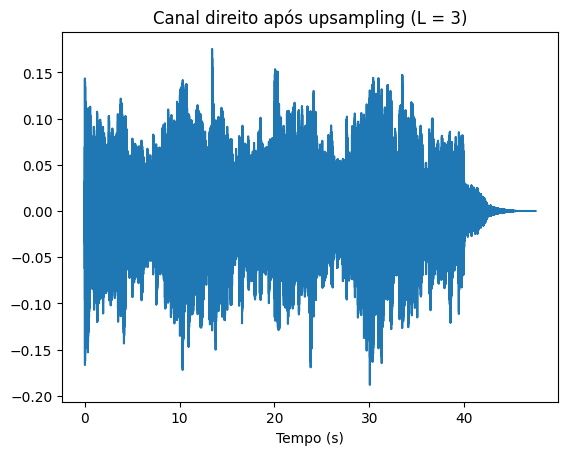

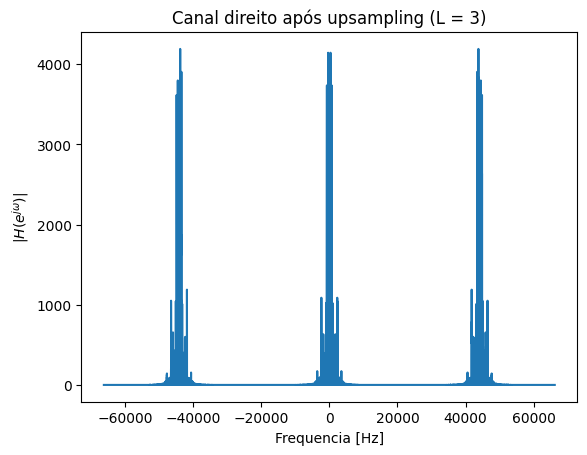

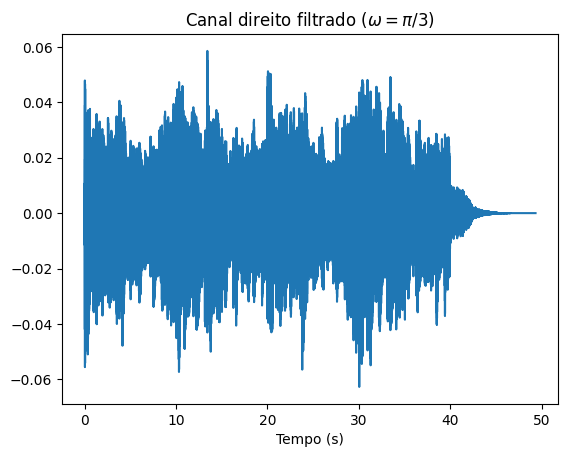

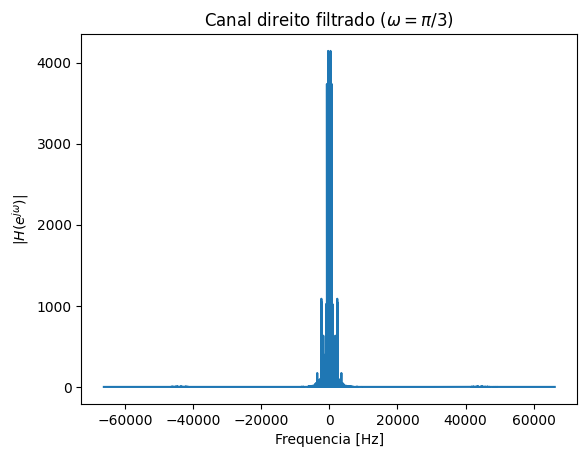

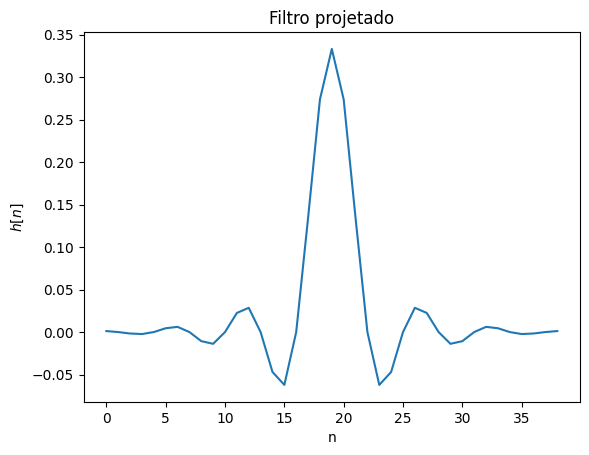

In [52]:
# Canal direito com upsampling (L = 3)
plot_time_domain(data_r_int,3*samplerate,"Canal direito após upsampling (L = 3)")
plot_centered_spectrum(data_r_int,len(data_r_int),1,3*samplerate,"Canal direito após upsampling (L = 3)")

# Canal direito filtrado (wc = pi/3)
plot_time_domain(data_yright,3*samplerate,"Canal direito filtrado ($\omega=\pi/3$)")
plot_centered_spectrum(data_yright,len(data_yright),1,3*samplerate,"Canal direito filtrado ($\omega=\pi/3$)")

# Plot do filtro
plt.figure()
plt.title("Filtro projetado")
plt.ylabel("$h[n]$")
plt.xlabel("n")
plt.plot(np.arange(len(coeffs)),coeffs)
